# Install Librairies

In [22]:
import tensorflow as tf
from os import listdir
from os.path import isfile, join
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib

from utils.conf import ROOT_DIR

# Configuration 

Check if gpu supported in this device

In [4]:
print(tf.__version__)

if tf.test.is_built_with_gpu_support():
    print("GPU is Supported")
else:
    print("GPU is not supported, check your configuration")

2.5.0
GPU is Supported


In [5]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [7]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [31]:
src_data = ROOT_DIR+"\\SOCOFing"
real_filenames = [src_data + "\\Real\\" + f for f in listdir(join(src_data, "Real"))
                  if isfile(join(src_data, "Real", f))]
digit_count = math.ceil(math.log10(len(real_filenames) + 1))

easy_filenames = [f for f in listdir(join(src_data, "Altered", "Altered-Easy"))
                  if isfile(join(src_data, "Altered", "Altered-Easy", f))]
medium_filenames = [f for f in listdir(join(src_data, "Altered", "Altered-Medium"))
                    if isfile(join(src_data, "Altered", "Altered-Medium", f))]
hard_filenames = [f for f in listdir(join(src_data, "Altered", "Altered-Hard"))
                  if isfile(join(src_data, "Altered", "Altered-Hard", f))]

num_images = len(real_filenames)
print("The very listed filename: {}".format(real_filenames[0]))


The very listed filename: C:\Users\anass\my_ds\fingerprint_class\SOCOFing\Real\100__M_Left_index_finger.BMP


In [35]:
import imageio
import random

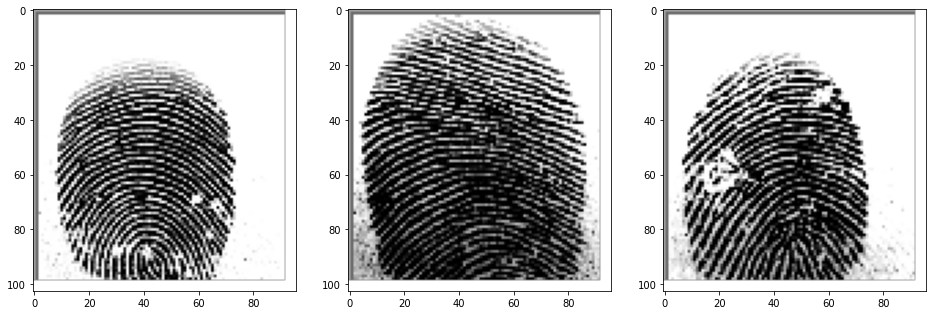

In [37]:
random.seed(42)

r = random.randint(0,num_images)
display_list = real_filenames[r:r+3]

image1 = imageio.imread(display_list[0])
image2 = imageio.imread(display_list[1])
image3 = imageio.imread(display_list[2])

fig, axes = plt.subplots(1,3,figsize = (16,16))
axes[0].imshow(image1)
axes[1].imshow(image2)
axes[2].imshow(image3)

In [38]:
from collections import defaultdict
import cv2


# Each finger (regardless of who it blongs to or which finger it is) will have an entry
# in this dictionary. And each entry is a list while variations of the finger are entries
# of the list. Something like: {"1": ["/path_to_the_file/1__M_Left_index_finger.BMP", ...]}
# Basically, we are grouping all variations of the same fingerprint. One real
# and the rest altered
unique_sample = defaultdict(list)

for fn in real_filenames:
    unique_sample[fn[:fn.rindex(".")]] += [join(src_data, "Real", fn)]
for fn in easy_filenames:
    unique_sample[fn[:fn.rindex("_")]] += [join(src_data, "Altered", "Altered-Easy", fn)]
for fn in medium_filenames:
    unique_sample[fn[:fn.rindex("_")]] += [join(src_data, "Altered", "Altered-Medium", fn)]
for fn in hard_filenames:
    unique_sample[fn[:fn.rindex("_")]] += [join(src_data, "Altered", "Altered-Hard", fn)]

# There are some unwanted pixels around the input images, this function will get rid of them
def load_image(file_path):
    # Load the image grayscale
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    # Get rid of the excess pixels
    img = img[2:-4, 2:-4]
    # make sure all the images are of the same size (90 * 97)
    img = cv2.resize(img, (90, 97))
    return img

# The number of samples per each group
training_sample_count = 3000
validation_sample_count = 1500
test_sample_count = 1500

# "0000_00" -> "/.../Real/1__M_Left_index_finger.BMP"
id2path = {}
# "0000_00" -> Mat/np.array
dataset_images = {}
# "0000" -> ["00", "01", ...]
training_ids = defaultdict(list)
# "4000" -> ["00", "01", ...]
validation_ids = defaultdict(list)
# "5000" -> ["00", "01", ...]
test_ids = defaultdict(list)

for sample_id, sample in enumerate(unique_sample.items()):
    for variation_id, f in enumerate(sample[1]):
        # Polish and move the files into new folders. New filenames: {sample_id}_{variation}.png
        zero_padded_sample_id = str(sample_id).zfill(digit_count)
        zero_padded_variation_id = str(variation_id).zfill(2)
        new_id =  f"{zero_padded_sample_id}_{zero_padded_variation_id}"
        id2path[new_id] = f
        dataset_images[new_id] = load_image(f)

        # Have the ids in three separate dicitonaries: sample_id -> [variation_id]
        if sample_id < training_sample_count:
            training_ids[zero_padded_sample_id] += [zero_padded_variation_id]
        elif sample_id < training_sample_count + validation_sample_count:
            validation_ids[zero_padded_sample_id] += [zero_padded_variation_id]
        else:
            test_ids[zero_padded_sample_id] += [zero_padded_variation_id]

print("There are {} samples in the training dataset".format(sum([len(ids) for ids in training_ids.values()])))
print("There are {} samples in the validation dataset".format(sum([len(ids) for ids in validation_ids.values()])))
print("There are {} samples in the test dataset".format(sum([len(ids) for ids in test_ids.values()])))

There are 3000 samples in the training dataset
There are 1500 samples in the validation dataset
There are 50770 samples in the test dataset


In [39]:
import numpy as np
import random as rnd
import cv2


eps = np.finfo(np.float32).eps

def data_generator(images, dataset, batch_size, image_transformer=None, shuffle=True):
    """Generator function that yields batches of images

    Args:
        folder (string): The path to the folder holder images
        batch_size (int): Number of elements per batch.
        image_transformer (function, optional): If provided is applied to each image before using it
        shuffle (bool, optional): If the batches should be randomnized or not. Defaults to True.
    Yields:
        tuple: Of the form (input1, input2) with types (numpy.ndarray, numpy.ndarray)
        NOTE: input1: inputs to the model [img1a, img2a, img3a, ...]
              input2: targets to the model [img1b, img2b, img3b, ...] i.e. (img1a, img1b) belong to the same fingerprint
    """

    if len(dataset) < batch_size:
        print("Batch size set to " + str(len(dataset)) + " as that's the total number of records")
        batch_size = len(dataset)

    if shuffle:
        indices = rnd.sample(list(dataset.keys()), len(dataset))
    else:
        indices = list(dataset.keys())

    idx = 0
    input1 = []
    input2 = []

    while True:
        if idx >= len(indices):
            idx = 0
            if shuffle:
                indices = rnd.sample(list(dataset.keys()), len(dataset))

        variations = rnd.sample(dataset[indices[idx]], 2)
        id1 = indices[idx] + "_" + variations[0]
        id2 = indices[idx] + "_" + variations[1]
        input1.append(id1)
        input2.append(id2)
        idx += 1

        if len(input1) == batch_size:
            b1 = []
            b2 = []
            if image_transformer is not None:
                for f1, f2 in zip(input1, input2):
                    b1.append(image_transformer(images[f1]))
                    b2.append(image_transformer(images[f2]))
            else:
                for f1, f2 in zip(input1, input2):
                    b1.append(images[f1])
                    b2.append(images[f2])

            yield np.array(b1), np.array(b2)
            input1, input2 = [], []


def prepare_random_image(image, angle1=-45.0, angle2=45.0, scale1=.9, scale2=1.1, dx1=-10, dx2=10, dy1=-10, dy2=10):
    angle = rnd.uniform(angle1, angle2)
    scale = rnd.uniform(scale1, scale2)
    dx = rnd.randint(dx1, dx2)
    dy = rnd.randint(dy1, dy2)
    
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, scale)
    trnl_mat = np.float32([ [0, 0, dx], [0, 0, dy] ])
    trns_mat = trnl_mat + rot_mat
    result = cv2.warpAffine(image, trns_mat, image.shape[1::-1],
                            flags=cv2.INTER_LINEAR,
                            borderValue=(255, 255, 255))
    return np.expand_dims(result, axis=-1).astype(np.float32)

In [ ]:
def normalize(x):
    return x / fastnp.sqrt(fastnp.sum(x * x, axis=-1, keepdims=True))

def model_f(d_model=128)
    with strategy.scope():
        model = tf.keras.Sequential([
          tf.keras.layers.Conv2D(16, (3,3), padding='VALID'),
          tf.keras.layers.MaxPooling2D(pool_size=(3,3), padding='VALID'),
          tf.keras.layers.Conv2D(32, (3,3), padding='VALID'),
          tf.keras.layers.MaxPooling2D(pool_size=(3,3), padding='VALID')
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(d_model*2),
          tf.keras.layers.Dense(d_model*3),
          tf.keras.layers.Dense(d_model,)
        ])

        model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])